In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from cloveFunctions import *
import matplotlib
matplotlib.use('Qt4Agg')
import matplotlib.pyplot as plt
# matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
import warnings
warnings.filterwarnings('ignore')

In [19]:
import pandas as pd
df = pd.DataFrame({ 'gene':["1 // foo // blabla",
                                   "2 // bar // lalala",
                                   "3 // qux // trilil",
                                   "4 // woz // hohoho",
                                   "nopeynope"], 
                   'cnv':['a','b','c','d','e'],
                   'cell1':[5,9,1,7,9], 
                   'cell2':[12,90,13,87,9],
                   'location':['1', '13.4', '1.1-2', '1.2-p22', '43-q44'],
                  'np_t_w': ['1','13.4','1.1','2','3']})
df['exp'] = ['e','f','g','h','i']
df

,cell1,cell2,cnv,gene,location,np_t_w,exp
0,5,12,a,1 // foo // blabla,1,1,e
1,9,90,b,2 // bar // lalala,13.4,13.4,f
2,1,13,c,3 // qux // trilil,1.1-2,1.1,g
3,7,87,d,4 // woz // hohoho,1.2-p22,2,h
4,9,9,e,nopeynope,43-q44,3,i


In [20]:
cnv = pd.DataFrame([[1,2,3],[4,5,6],[7,8,9]], index=['a', 'b','x'])
exp = pd.DataFrame([[1,2,3],[4,5,6],[7,8,9]], index=['e', 'h','x'])

In [17]:
df[(df['cnv'].isin(cnv.index)) & (df['exp'].isin(exp.index))]

,cell1,cell2,cnv,gene,location,np_t_w,exp
0,5,12,a,1 // foo // blabla,1,1,e


In [23]:
results = []
for pddf in [df, cnv, exp]:
    results.append(pddf)

for p in results:
    print(p)


   cell1  cell2 cnv                gene location np_t_w exp
0      5     12   a  1 // foo // blabla        1      1   e
1      9     90   b  2 // bar // lalala     13.4   13.4   f
2      1     13   c  3 // qux // trilil    1.1-2    1.1   g
3      7     87   d  4 // woz // hohoho  1.2-p22      2   h
4      9      9   e           nopeynope   43-q44      3   i
   0  1  2
a  1  2  3
b  4  5  6
x  7  8  9
   0  1  2
e  1  2  3
h  4  5  6
x  7  8  9


In [10]:
df['location'].str.extract('(-)', expand=True)

,0
0,NaN
1,NaN
2,-
3,-
4,-


In [16]:
df = pd.DataFrame([['a','b',1,'1p1'],
                  ['a','c',1.9,'1p1'],
                  ['a','d',45,'1p1'],
                  ['a','e',3.9,'1p1'],
                  ['b','c', 2.1,'1p2'],
                  ['b','d',-2,'1p2'],
                  ['b','e',4.1,'1p2'],
                  ['c','b',2,'1p3'],
                  ['c','c',2,'1p3'],
                  ['c','d',2,'1p3'],
                  ['c','e',2,'1p3'],
                  ['d','b',2,'1p4'],
                  ['d','c',2,'1p4'],
                  ['d','d',2,'1p4'],
                  ['d','e',2,'1p4']],
                 columns = ['cnv','exp','np_t_w', 'chromosome'])
df

,cnv,exp,np_t_w,chromosome
0,a,b,1.0,1p1
1,a,c,1.9,1p1
2,a,d,45.0,1p1
3,a,e,3.9,1p1
4,b,c,2.1,1p2
5,b,d,-2.0,1p2
6,b,e,4.1,1p2
7,c,b,2.0,1p3
8,c,c,2.0,1p3
9,c,d,2.0,1p3


In [32]:
rolling_similarity(df, how='cosine', group='cnv',data='np_t_w')

  chromosome cnv_g0 exp  clove_g0 cnv_g1  clove_g1
0        1p1      a   c       1.9      b       2.1
1        1p1      a   d      45.0      b      -2.0
2        1p1      a   e       3.9      b       4.1
  chromosome cnv_g0 exp  clove_g0 cnv_g1  clove_g1
0        1p1      a   b       1.0      c       2.0
1        1p1      a   c       1.9      c       2.0
2        1p1      a   d      45.0      c       2.0
3        1p1      a   e       3.9      c       2.0
  chromosome cnv_g0 exp  clove_g0 cnv_g1  clove_g1
0        1p1      a   b       1.0      d       2.0
1        1p1      a   c       1.9      d       2.0
2        1p1      a   d      45.0      d       2.0
3        1p1      a   e       3.9      d       2.0
  chromosome cnv_g0 exp  clove_g0 cnv_g1  clove_g1
0        1p2      b   c       2.1      c       2.0
1        1p2      b   d      -2.0      c       2.0
2        1p2      b   e       4.1      c       2.0
  chromosome cnv_g0 exp  clove_g0 cnv_g1  clove_g1
0        1p2      b   c       2

,cnv,exp,cosine
0,a,b,-0.308410
1,a,c,0.572759
2,a,d,0.572759
3,b,c,0.482854
4,b,d,0.482854
5,c,d,1.000000


In [31]:
from scipy.stats import pearsonr
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity

def rolling_similarity(df, group='cnv', partners='exp', data='np_t_w', how='pearson', locus='chromosome'):
    """
    computes similarity between array of data for one gene partners and each successive chromosomal neighbor
    
    :param df: pd df, clove results, sorted in ascending order of chromosome locus
    :param group: str, df column label on which to form gene neigbors, default 'cnv'
    :param members: str, df column label on which to pair partners with gene neighbors, default 'exp'
    :param data: str, df column label of source data to populate arrays, default 'np_t_w' (clove t-stats)
    :param how: str, choice of: {pearson, euclidian, cosine}
    :param align: bool, False compares two arrays which don't necessarily have same gene index
    
    returns pd df of pairs, scores, and chosen similary metric, ordered by locus
    """
    
    unique_genes = df[group].unique()
    df = df[[locus, group, partners, data]].sort_values(by=locus)
    results = []
    for idx, g0 in enumerate(unique_genes):
        if idx < len(unique_genes) - 1:
            for idxk, gk in enumerate(unique_genes[idx+1:]):
                g1 = gk  # unique_genes[idx+1]
                merged = pd.merge(df[df[group] == g0], df[df[group] == g1][[partners,group,data]], how='inner', on=partners)
                merged.columns = [locus,'cnv_g0','exp','clove_g0','cnv_g1','clove_g1']
                print(merged)

                if how == 'pearson':
                    # produces NaN
                    cols = [group, partners, how ,'pval']
                    pear, pval = pearsonr(merged['clove_g0'], merged['clove_g1'])
                    results.append([g0,g1,pear,pval])
                elif how == 'euclidian':
                    cols = [group, partners, how]
                    d = distance.euclidean(merged['clove_g0'], merged['clove_g1'])
                    # error: (offx>=0 && offx<len(x)) failed for 2nd keyword offx: dnrm2:offx=0
                    results.append([g0, g1, d])
                elif how == 'cosine':
                    cols = [group, partners, how]
                    # error: (offx>=0 && offx<len(x)) failed for 2nd keyword offx: dnrm2:offx=0
                    d = cosine_similarity(merged['clove_g0'], merged['clove_g1'])[0][0]  
                    results.append([g0, g1, d])

#     return map_locus(pd.DataFrame(results, columns=cols))
    return pd.DataFrame(results, columns=cols)

In [27]:
df

,cell1,cell2,cnv,gene,location,np_t_w
0,5,12,a,1 // foo // blabla,1,1
1,9,90,b,2 // bar // lalala,13.4,13.4
2,1,13,c,3 // qux // trilil,1.1-2,1.1
3,7,87,d,4 // woz // hohoho,1.2-p22,2
4,9,9,e,nopeynope,43-q44,3


In [13]:
pearsonr?

develop explicit way to define certain combinations of genes on which to compute CLOvEs

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from cloveFunctions import *
import itertools

In [2]:
edf = pd.read_csv('data/breast_mrna.tab.gz', compression='gzip', sep='\t', index_col=0)
cdf = pd.read_csv('data/breast_CCLE_DEL_calls.csv.gz', compression='gzip', index_col=0)

In [3]:
e_samp = edf.index[1:3].values
c_samp = cdf.index[3:5].values

In [4]:
c_samp

array(['A2LD1', 'A2M'], dtype=object)

In [5]:
edf_f, cdf_f = mainFitler(edf, cdf, var=2, n=6, amp_fh=False, dele_fh=False, mut_fh=False, save=False)
df = explicitPairContextStat(edf_f, cdf_f, cnv_lis=c_samp)

attempting 3376 comparisons with current parameters


In [7]:
map_locus(df)

,cnv,exp,pos_n,neg_n,pos_mu,neg_mu,pos_var,neg_var,cohens_d,np_t_w,np_p_w,gene_var_exp,chromosome
0,A2M,AP1S2,6,53,7.319589,7.507049,1.387391,2.894021,-0.111297,-0.258386,0.797039,2.791326,12p13.31
22,A2M,MIEN1,6,53,11.207608,11.165550,2.228997,2.436755,0.026598,0.0617499,0.950978,2.457440,12p13.31
23,A2M,MLPH,6,53,10.511819,10.505350,5.335603,4.699409,0.002913,0.00676354,0.994627,4.846250,12p13.31
24,A2M,MREG,6,53,7.900807,7.478374,0.970711,2.610663,0.265600,0.616617,0.539942,2.502608,12p13.31
25,A2M,NAT1,6,53,8.542979,8.340457,3.623388,2.661422,0.119836,0.278212,0.781857,2.810634,12p13.31
26,A2M,OPN3,6,53,7.683450,8.180795,1.802795,2.257083,-0.328765,-0.763261,0.448455,2.271989,12p13.31
27,A2M,PDCD4,6,53,8.866148,8.602590,3.990745,2.304567,0.164630,0.382205,0.703731,2.525188,12p13.31
28,A2M,PLEKHF2,6,53,9.611975,9.099866,0.481288,2.389591,0.339707,0.788664,0.433576,2.257751,12p13.31
29,A2M,PLK2,6,53,11.220978,10.387761,0.711472,2.207939,0.571194,1.32608,0.190101,2.155715,12p13.31
30,A2M,RAB11FIP1,6,53,8.788833,8.510063,0.573247,2.737802,0.172686,0.400909,0.689986,2.568308,12p13.31


In [39]:
df['exp'].value_counts()

SH3YL1          2
RHPN2           2
HIST1H2BD       2
OPN3            2
HIST2H2BE       2
PLEKHF2         2
LOC100128822    2
MLPH            2
PLK2            2
SNHG5           2
NAT1            2
IL6ST           2
TSPAN13         2
CXXC5           2
RND3            2
DYNLT3          2
TRPS1           2
DNAJB4          2
RAB11FIP1       2
COTL1           2
FAM69A          2
MREG            2
IKBIP           2
AP1S2           2
SFN             2
KDELR3          2
RHOBTB3         2
MIEN1           2
CD9             2
FRMD6           2
HES1            2
TFAP2A          2
CEBPD           2
CREB3L4         2
SLC7A11         2
FAM46A          2
ID1             2
EXT1            2
MAFF            2
PDCD4           2
ELL3            2
Name: exp, dtype: int64

In [ ]:
cbar = fig.colorbar

### Subset large intestine data to get to 5 viz bait contexts

large intestine (source of viz dataset) doesn't have enough n-samples with context (probably why these were induced knockouts)"

In [8]:
csv = pd.read_csv('data/large_intestine_CCLE_DEL_calls.csv.gz', compression='gzip', index_col=0)
viz_bait = ['PTTG1', 'BLM','MUS81', 'PTEN', 'KRAS']
csv.loc[viz_bait].sum(axis=1)
# csv[csv['Name'].isin(viz_bait)]

Name
PTTG1    0
BLM      0
MUS81    2
PTEN     1
KRAS     0
dtype: int64

use all ccle cell lines

In [9]:
csv = pd.read_pickle('data/CCLE_DEL_calls.pickle')
viz_bait = ['PTTG1', 'BLM','MUS81', 'PTEN', 'KRAS']
csv = csv.loc[viz_bait].sum(axis=1)
csv.to_pickle('data/CCLE_DEL_calls_viz.pickle')

Name
PTTG1     18
BLM       19
MUS81      9
PTEN     102
KRAS      31
dtype: int64

In [4]:
explicitPairContextStat?

In [10]:
viz = pd.read_csv('data/viz_HCT116_GARP-score.txt.tar.gz',sep='\t', compression='gzip', index_col=0)

In [11]:
del viz['Gene ID']
del viz['Description']
del viz['Unnamed: 10']
viz.set_index('Gene Name', drop=True, inplace=True)
viz

,HCT116_BLM,HCT116_MUS81,HCT116_PTEN,HCT116_PWT,HCT116_PTTG1,HCT116_WT
Gene Name,,,,,,
WDR11,-0.156363,-0.306122,-0.357102,-0.084159,-0.413263,-0.121228
OR10A2,-0.055357,-0.109505,-0.077226,-0.070077,-0.127857,-0.059772
MRPS12,-0.111989,-0.059505,-0.184910,-0.066028,-0.217499,-0.039225
MPV17L,-0.036167,-0.148610,-0.225790,-0.068753,-0.239617,-0.051944
TFPI2,-0.180304,-0.315834,-0.387426,-0.190001,-0.292052,-0.091514
NUDT15,-0.019991,-0.096132,-0.135179,-0.073432,-0.187830,-0.051562
TRMT1,-0.319461,-0.101908,-0.093429,-0.118008,-0.220807,-0.064457
PNOC,0.019299,-0.086702,-0.001842,-0.071489,-0.029707,-0.009812
EVI2B,-0.018433,-0.155776,-0.078900,-0.057902,-0.229445,-0.065921


## Compute Some Sample Breast CLOvE

In [ ]:
from cloveFunctions import *

def compute_breast_cloves(save=False):
    exp_breast = pd.read_pickle('data/breast_mrna_df.pickle')
    cdel = pd.read_pickle('data/CCLE_DEL_calls.pickle')
    cell = pd.read_pickle('data/ccle_cell_info_df.pickle')

    # this filtering step requires subsetting cdel to tissue of interest (breast)
    cells = list(set(cdel.columns).intersection(exp_breast.columns)) # eliminating all contexts less than 2
    cdel_breast = cdel[cells]
    df=randomPairContextStat(100000, exp_breast, cdel_breast, nan_style='propagate')
    
    if save:
        df.to_csv('data/breast_ttest_real_samp.tab.gz', sep='\t', compression='gzip')
    return df

def load_breast_cloves():
    return  pd.read_csv('data/breast_ttest_real_samp.tab.gz', sep='\t', compression='gzip', index_col=0)

# Compute 1M Sample Breast CLOvE

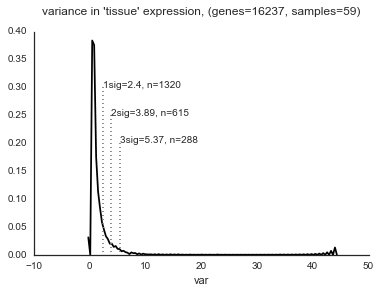

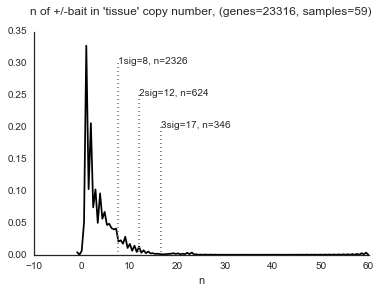

In [2]:
%matplotlib inline
expdf, cnvdf = load_data('data/breast_mrna.tab.gz', 'data/breast_CCLE_DEL_calls.csv.gz')

In [3]:
expdf, cnvdf = mainFitler(expdf, cnvdf, var=2, n=8)

exp: (16237, 59) --> filter --> (1688, 59)
cnv: (23316, 59) --> filter --> (2278, 59)
3845264 CLOvE pairs are possible with these parameters
estimated calculation time: 44.86141333333333min (~7sec/10k pairs)


## Compute Some Sample Breast CLOvE
that match with pre computed cloves from some other set

In [ ]:
def matchPairContextStat(expdf, cnvdf, new_cohort, matchdf, match_cohort, nan_style='omit', permute=False):
    """
    computes clove pairs from one sample that match with those computed in some other cohorts
    
    :param expdf: pandas dataframe, expression by sample 
                    (hopefully filtered with mainFilter, tissue specific, with matching samples in cnv)
    :param cnvdf: pandas dataframe, binarized mask 5(1=delete, 0=nodelete) deletion by sample 
                    (hopefully filtered with mainFilter, tissue specific, with matching samples in exp)
    :param new_cohort: str, identifier for the current cohort computation (eg, tissue origin of exp and cnv)
    :param matchdf: pandas dataframe, results of clove computation performed in other cohort
                    exp and cnv pairs will be used to populate the new clove results so pairs match between cohort
    :param match_cohort: str, identifier for the matching (precomputed) cohort used (eg, tissue origin of matchdf)
    :param nan_style: str, how the stats.ttest_ind treats NANs, {‘propagate’, ‘raise’, ‘omit’}
    :param permute: bool, True will calculate pairs with randomly permuted expression matrix as null model
    
    returns df[['exp', 'cnv', 'cntxt_pos_mu', 'cntxt_neg_mu', 
                'cntxt_pos_var', 'cntxt_neg_var', 
                'cntxt_pos_n', 'cntxt_neg_n']]
    """
    
    cells = list(set(cnvdf.columns).intersection(expdf.columns)) # confirm same samples in both cnv and exp
    expdf = expdf[cells]
    cmask = cnvdf[cells] == 1
    
    df = matchdf[['exp', 'cnv', 'np_t_w', 'np_t_w_null','np_p_w']]
    df.columns = ['exp', 'cnv', 't_'+match_cohort, 't_null_'+match_cohort, 'p_'+match_cohort,]
    
    if permute:
        cmask_n = scrambleDF(cmask)
    
#     only keep elements of matchdf['exp'] that are also in expdf.index
    df = df[(df['exp'].isin(expdf.index)) & (df['cnv'].isin(cnvdf.index))]
    print('attempting {} comparisons referenced from {}'.format(shape.df[0], match_cohort))
    
    np_t_w, np_p_w, np_t_w_null = [], [], []
  
    # progress initialize
    count=0
    percent_complete=0
    comparisons = shape.df[0]
    
    for row in df.itertuples():
        # progress report
        count+=1
        if count%(comparisons/10)==0:
            percent_complete+=10
            print('pair computation {}% complete ({}/{})'.format(percent_complete, count, comparisons))
        
        # mask cnv contexts onto expression data
        pos = np.array(expdf.loc[row.exp][cmask.loc[row.cnv]])
        neg = np.array(expdf.loc[row.exp][~cmask.loc[row.cnv]])
        
        # calculate t_stat, welch
        t, p = stats.ttest_ind(pos, neg, nan_policy=nan_style, equal_var=True)
        
        if permute:
            pos = np.array(expdf.loc[row.exp][cmask_n.loc[row.cnv]])
            neg = np.array(expdf.loc[row.exp][~cmask_n.loc[row.cnv]])
            t, p = stats.ttest_ind(pos, neg, nan_policy=nan_style, equal_var=True)
            np_t_w_null.append(t)
   
    df['t_'+new_cohort] = np_t_w
    df['p_'+new_cohort] = np_p_w
    
    if permute:
        df['t_null_'+new_cohort] = np_t_w_null
        
    return df

## graph distribution of copy numer in LUNG CCLE 

In [2]:
calls = pd.read_pickle('data_large/CCLE_DEL_calls.pickle')
cellinfo = pd.read_pickle('data_large/ccle_cell_info_df.pickle')
lungcnv = pd.read_pickle('data/lung_cnv_df.pickle')
lungexp = pd.read_pickle('data/lung_mrna_df.pickle')

In [4]:
cellinfo

,Cell line primary name,Cell line aliases,Gender,Site Primary,Histology,Hist Subtype1,Notes,Source,Expression arrays,SNP arrays,Oncomap,Hybrid Capture Sequencing
CCLE name,,,,,,,,,,,,
1321N1_CENTRAL_NERVOUS_SYSTEM,1321N1,NaN,M,central_nervous_system,glioma,astrocytoma,"Identical lines: U-118 MG, U-138 MG and 1321N1...",ECACC,NIECE_p_NCLE_RNA3_HG-U133_Plus_2_B06_296024,HONEY_p_NCLE_DNAAffy3_S_GenomeWideSNP_6_E09_29...,yes,NaN
143B_BONE,143B,NaN,F,bone,osteosarcoma,NS,"Identical lines: HTK-, HOS and 143B share high...",ATCC,MAKER_p_NCLE_RNA7_HG-U133_Plus_2_F09_454702,BOWER_p_NCLE_DNAAffy8_GenomeWideSNP_6_D02_464552,yes,NaN
22RV1_PROSTATE,22Rv1,NaN,M,prostate,carcinoma,NS,NaN,ATCC,NIECE_p_NCLE_RNA3_HG-U133_Plus_2_F06_296120,LIMPS_p_NCLE_DNA2N_GenomeWideSNP_6_C09_246674,yes,yes
2313287_STOMACH,23132/87,NaN,M,stomach,carcinoma,adenocarcinoma,NaN,DSMZ,WATCH_p_NCLE_RNA8_HG-U133_Plus_2_E11_474718,CHARY_p_NCLE_DNAAffy9_GenomeWideSNP_6_D06_490336,yes,yes
253JBV_URINARY_TRACT,253J-BV,NaN,U,urinary_tract,carcinoma,transitional_cell_carcinoma,Identical lines: 253J and 253J-BV share high S...,KCLB,CRAZY_p_NCLE_RNA10_HG-U133_Plus_2_A05_569490,NaN,yes,yes
253J_URINARY_TRACT,253J,NaN,NaN,urinary_tract,carcinoma,transitional_cell_carcinoma,Identical lines: 253J and 253J-BV share high S...,KCLB,CRAZY_p_NCLE_RNA10_HG-U133_Plus_2_A03_569510,NaN,yes,yes
42MGBA_CENTRAL_NERVOUS_SYSTEM,42-MG-BA,NaN,M,central_nervous_system,glioma,astrocytoma_Grade_IV,NaN,DSMZ,NIECE_p_NCLE_RNA3_HG-U133_Plus_2_B02_296016,HONEY_p_NCLE_DNAAffy3_S_GenomeWideSNP_6_E05_29...,yes,yes
5637_URINARY_TRACT,5637,NaN,M,urinary_tract,carcinoma,NS,NaN,ATCC,AGENT_p_NCLE_RNA6_HG-U133_Plus_2_F08_436450,MISTS_p_NCLE_DNAAffy11_GenomeWideSNP_6_C05_578366,yes,yes
59M_OVARY,59M,NaN,F,ovary,carcinoma,NS,NaN,ECACC,GAZER_p_NCLE_Expr_P13_HG-U133_Plus_2_A10_779748,MISTS_p_NCLE_DNAAffy11_GenomeWideSNP_6_F10_578312,yes,yes


In [6]:
lungcnv, lungexp = ccleTissueSelect?

In [ ]:
lungcnv, lungexp = ccleTissueSelect

In [ ]:
lungcnv, lungexp = clv.ccleTissueSelect

In [ ]:


def graph_n_ratio(df, tissue, y0=0.5, yd=0.05):
    """
    plots split number (n) of +/-bait contexts in the raw cnvdf before you decide how to filter
    
    :param df: pandas dataframe, raw copy number dataframe gene x sample
    :param tissue: str, name of tissue or cohort of interest, just for labeling
    :param y0: float, top of sig line and label
    :param yd: float, how much y0 should decrease to fit subsequent sig below it
    
    returns None, just displays a plot"""
    n_arr = df.sum(axis=1)
    sns.set_style("white")
    plt.xlabel('n')
    sns.distplot(n_arr, color='black', hist=False)

    for x in range (1,4):
        sig=round(np.std(n_arr)*x+np.mean(n_arr), 2)
        n=df[df.sum(axis=1) > sig].shape[0]
        plt.plot([sig,sig], [y0, 0], linestyle='dotted', color='gray')
        sig_label = '{}sig={}, n={}'.format(str(x), str(int(round(sig, 0))), str(n))
        plt.text(sig, y0, sig_label)
        y0 -= yd
    sns.despine()
    plt.title('n of +/-bait in {} copy number, (genes={}, samples={})\n'.format(tissue, df.shape[0], df.shape[1]))
    plt.show()

## Compute Some Sample Lung CLOvE

In [1]:
from cloveFunctions import *

In [4]:
# bring in exp and cnv data from
# G:\My Drive\Python Scripts\clove\tissueDF_raw



To Do
Debug matchPairContextStat func in tgca_vs_ccle.ipynb
Add save parameter
Run above func to compute CCLE lung matching pairs in data/tcga_lung_cloves.tab.gz
Write function to Graph Scatter (with 3𝞭 cutoff) 
Graph above func for lung CCLE vs TCGA
Run millions of comparisons in TCGA BRCA
Re-run millions of comparisons in CCLE breast?
If not, use existing CCLE breast cloves to dictate which pairs tested
Run millions of comparisons in TCGA BRCA
Housekeeping
Func load_data created to handle raw input files directly
Relies on Func graph_var_dist and graph_n_dist to display summary stats n and var for use in filtering
TODO add in tissue/cohort subset option
Func matchPairContextStat computes pairs in new data according to pairs defined in old data.  Used to match pair for pair across each cohort
TODO test/debug in ccle_sandbox
